# Contour Matvec  Speed Experiment
This experiments focus on the contour experiment. The code is organized into two parts:
- Plots: Plot function to load data and make refined plots 
- Data: Experiments to generate the corresponding data 

## Data 
The experiment is divided into 3 parts. 
- Eigenvalues: We should the egivenvalues of corresponding discretized Laplacian. We will try to match the eigenvalues but only change the dimension.
- $N_{poles}$ selection: For different temperature, the corresponding number of poles should be different. We present some function on how to select $N_{poles}$. 
- Change $\beta$ or change Eigenvalues. We showed that with changing eigenvalues or $\beta$, how the computational time change.

### Eigenvalues 

We fix the sizes for 1D, 2D, and 3D experiments but changing $L$. The sizes are $(11,11,11),(31,31),(1001,)$. The main idea here is to make sure their dimensions are very close.

In [1]:
import os 
import sys 

print(os.getcwd()) # print the current working directory
sys.path.append(os.path.join(os.getcwd(), '..','..')) # add the root directory to the path
os.chdir("../..")
print(os.getcwd())
from src import *
os.environ['CUDA_VISIBLE_DEVICES'] = '1' 
from benchmarks.benchmark_tool import benchmark_contour


/home/jovyan/project/MirrorDescent-DFT/figures/fig_contour_matvec_speed
/home/jovyan/project/MirrorDescent-DFT


0.0 -9.869604401089358
0.0 -9.712322385353596
0.0 -9.095827416043953


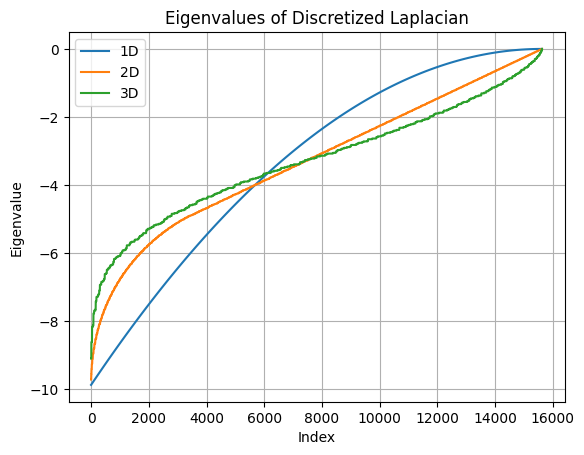

In [2]:
base_dim = 5
Nss = [(base_dim**6,), 
        (base_dim**3,base_dim**3), 
        (base_dim**2, base_dim**2, base_dim**2)] # 1D, 2D, 3D
Lss = [(base_dim**6-1,), 
        ((base_dim**3)*np.sqrt(2), (base_dim**3)*np.sqrt(2)), 
        ((base_dim**2)*np.sqrt(3), (base_dim**2)*np.sqrt(3), (base_dim**2)*np.sqrt(3))] # 1D, 2D, 3D
# alphas = [1,2,3]
eigs = np.zeros([3, 5**6])
for i in range(len(Nss)):
    Ns = Nss[i]
    Ls = Lss[i]
    eigenvalues = genDiscretizedLaplacianEigenvalues(Ns, Ls) 
    eigs[i, :] = eigenvalues.flatten()

plt.figure() 
for i in range(3):
    eig = eigs[i, :].flatten()
    eig = np.sort(eig)
    print(np.max(eig), np.min(eig))
    plt.plot(eig, label=f'{i+1}D')
plt.legend()    
plt.grid(True)
plt.xlabel('Index')
plt.ylabel('Eigenvalue')
plt.title('Eigenvalues of Discretized Laplacian')
plt.show()  


### $N_{poles}$ selection 

The number of poles can be affected by two different things. The first thing is the range of eigenvalues. The second thing is the inverse temperature. Actually, they can be merged together into a single quantity $\beta \|H\|_2$. Only this quantity will influence the shape of contour poles and accuracy of the approximation. Hence, we focus on this.


In [3]:
from tqdm import tqdm

betas = 2**np.linspace(1,12,12)
Ns = np.linspace(1,100,100).astype(int)
errors = np.zeros((len(betas),len(Ns)))
EM = 1
Em = -1
mu = 0
x = np.linspace(-1,1,1000)
for i in range(len(betas)):
    true_f = np.sqrt(1/(1+np.exp(betas[i]*np.clip(x-mu, -500/betas[i], 500/betas[i]))))
    for j in tqdm(range(len(Ns))):
        xi, w = gen_contour(Em, EM, betas[i], Ns[j], mu=mu, function='fermi_dirac',clip=False)
        esti_f = contour_f(x,xi,w)
        errors[i,j] = np.max(np.abs(true_f-esti_f))


100%|██████████| 100/100 [00:00<00:00, 249.63it/s]


In [10]:
print(true_f[:10])
print(esti_f[:10])

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[9.21526581e-14 9.23290443e-14 9.25057828e-14 9.26828465e-14
 9.28615231e-14 9.30440756e-14 9.32214511e-14 9.34046541e-14
 9.35852280e-14 9.37663982e-14]


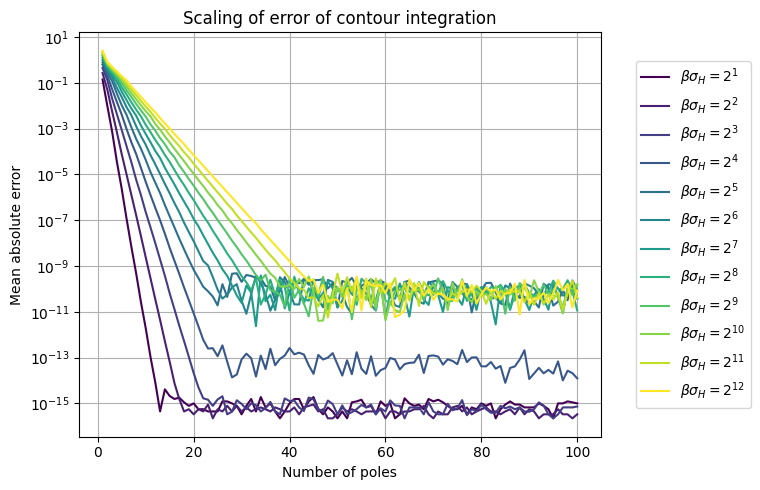

In [16]:
plt.figure(figsize=(8,5), dpi=100)
# Create a colormap from viridis
colors = plt.cm.viridis(np.linspace(0, 1, len(betas)))
for i in range(len(betas)):
    plt.semilogy(Ns, errors[i,:], label=r'$\beta \sigma_H=2^{'+str(i+1)+'}$', color=colors[i])
plt.legend(loc='right', bbox_to_anchor=(1.3, 0.5))
plt.ylabel("Mean absolute error")
plt.xlabel("Number of poles")
plt.title("Scaling of error of contour integration")
plt.grid(True)
plt.tight_layout()
plt.show()

In [17]:
coefficients = np.zeros([len(betas),2]) 
log_errors = np.log10(errors) 
for i in range(len(betas)):
    # print(log_errors[i,:])
    index = np.where(np.logical_and(log_errors[i,:] < -1, log_errors[i,:] > -9))[0]
    lr_y = log_errors[i,index]
    lr_x = Ns[index]
    coefficients[i,:] = np.polyfit(lr_x, lr_y, 1) 
    # print(f"Slope for beta={betas[i]}: {coefficients[i,0]:.2f}")
    # print(f"Intercept for beta={betas[i]}: {coefficients[i,1]:.2f}")

print(1/coefficients[:,0])
print(coefficients[:,1])
n_poles = (-20-coefficients[:,1])/coefficients[:,0]
n_poles = np.floor(n_poles).astype(int)
print(n_poles)
print(betas)

[-0.80920085 -1.09917201 -1.4167529  -1.73249433 -2.05798886 -2.39444646
 -2.70158723 -3.02695037 -3.34612501 -3.67178807 -4.00015097 -4.32054665]
[0.51378995 0.48514214 0.45570279 0.4730079  0.476739   0.45481529
 0.48418315 0.480975   0.48911823 0.48284083 0.47391234 0.47558127]
[16 22 28 35 42 48 55 61 68 75 81 88]
[2.000e+00 4.000e+00 8.000e+00 1.600e+01 3.200e+01 6.400e+01 1.280e+02
 2.560e+02 5.120e+02 1.024e+03 2.048e+03 4.096e+03]


In [18]:
betas = np.linspace(1,500,100)
M = 5
x = np.linspace(-1,1,1000)
EM= 1
Em= -1
mu = 0
N_poles = ((M+0.5)*(0.5 +0.3*np.log2(betas))+2).astype(int)
print(N_poles)
print(N_poles)
errors_new = []

# print(x)
for i in tqdm(range(len(betas))):
    true_f = np.sqrt(1/(1+np.exp(betas[i]*np.clip(x-mu, -400/betas[i], 400/betas[i]))))
    xi, w = gen_contour(Em, EM, betas[i], N_poles[i], mu=mu, function='fermi_dirac')
    esti_f = contour_f(x,xi,w)
    errors_new.append(np.max(np.abs(true_f-esti_f)).item())

print(np.max(errors_new))

[ 4  9 10 11 12 12 12 13 13 13 14 14 14 14 14 15 15 15 15 15 15 15 15 16
 16 16 16 16 16 16 16 16 16 16 17 17 17 17 17 17 17 17 17 17 17 17 17 17
 17 17 17 17 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18
 18 18 18 18 18 18 18 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19
 19 19 19 19]
[ 4  9 10 11 12 12 12 13 13 13 14 14 14 14 14 15 15 15 15 15 15 15 15 16
 16 16 16 16 16 16 16 16 16 16 17 17 17 17 17 17 17 17 17 17 17 17 17 17
 17 17 17 17 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18
 18 18 18 18 18 18 18 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19
 19 19 19 19]


100%|██████████| 100/100 [00:00<00:00, 304.87it/s]

7.814972162067946e-06


### Matvec Speed

In [3]:
from benchmarks.benchmark_tool import benchmark_contour

base_dim = 3
Nss = [(base_dim**6,), 
        (base_dim**3,base_dim**3), 
        (base_dim**2, base_dim**2, base_dim**2)] # 1D, 2D, 3D
Lss = [(base_dim**6-1,), 
        ((base_dim**3-1)*np.sqrt(2), (base_dim**3-1)*np.sqrt(2)), 
        ((base_dim**2-1)*np.sqrt(3), (base_dim**2-1)*np.sqrt(3), (base_dim**2-1)*np.sqrt(3))] # 1D, 2D, 3D

test_size = 20 
beta = 100
betas = np.linspace(11, 40, 30)
N_poles = 20
N_samples = 20 

info = np.zeros([3, len(betas), 4])
for i in range(len(betas)):
        beta = betas[i]
        for dim in tqdm(range(len(Nss))):
                print(f'Scaling of {dim+1}D contour solver')
                Ns = Nss[dim]
                Ls = Lss[dim]
                info[dim, i, :] = benchmark_contour(Ns, Ls,N_poles, N_samples, beta, test_size=test_size, gen_N_poles=True, verbose=False,tol=1e-5,check_error=True) 



  0%|          | 0/3 [00:00<?, ?it/s]

Scaling of 1D contour solver
4.707683960507582
N_poles: 20


  0%|          | 0/3 [00:02<?, ?it/s]


AttributeError: 'list' object has no attribute 'mean'

In [8]:
from benchmarks.benchmark_tool import benchmark_contour

Ns = (729,)
Ls = (726,)
N_poles = 20
N_samples = 20
beta = 20
test_size = 20
elapsed_time, errors = benchmark_contour(Ns, Ls,N_poles, N_samples, beta, test_size=test_size, gen_N_poles=True, check_error=True, verbose=True,tol=1e-5)
print(elapsed_time) 
print(errors)

energy_min: -1.8940109623206798, energy_max: 4.733441056915783
4.733441056915783
N_poles: 15
[0.03043980395887047, 0.02892149903345853, 0.026758596010040492, 0.0267380450386554, 0.02737250499194488, 0.026792315009515733, 0.02837360999546945, 0.026963277952745557, 0.027578487992286682, 0.02659826196031645, 0.02453052904456854, 0.024369366990868002, 0.024892865971196443, 0.02507563796825707, 0.025273440987803042, 0.02660767297493294, 0.02457519999006763, 0.02529482200043276, 0.02550390496617183, 0.026049434032756835]
[1.8850434041041663e-06, 1.8541482488781145e-06, 1.8223544436875599e-06, 1.7118702167323794e-06, 1.8249820661514377e-06, 1.7928311486140245e-06, 1.737504145428101e-06, 1.8033222224516014e-06, 1.868957051980974e-06, 1.8750948997648e-06, 1.6861767534478288e-06, 1.7471534268600902e-06, 1.8424021922636537e-06, 1.8141846835842521e-06, 1.7969738829373945e-06, 1.6961159438886941e-06, 1.7985648948349155e-06, 1.791973691790022e-06, 1.756707490223149e-06, 1.71715610102892e-06]


In [7]:
print(3**6)

729
